# 🌱 **Smart Agriculture: CNN-Based Potato Disease Detection System**

## 🧠 *Using Dual-Branch CNN with Attention Mechanism*


In [1]:
import kagglehub
path = kagglehub.dataset_download("aarishasifkhan/plantvillage-potato-disease-dataset")
print("Dataset downloaded to:", path)


Dataset downloaded to: /kaggle/input/plantvillage-potato-disease-dataset


In [2]:
import os
print(os.listdir(path))

['PlantVillage']


In [3]:
base_path = os.path.join(path,"PlantVillage")

In [4]:
print(os.listdir(base_path))

['Potato___healthy', 'Potato___Late_blight', 'Potato___Early_blight']


In [5]:
categories = os.listdir(base_path)
categories

['Potato___healthy', 'Potato___Late_blight', 'Potato___Early_blight']

In [6]:
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)

print(len(image_paths))
print(len(labels))

2152
2152


In [7]:
import pandas as pd

df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

df.head()



,image_path,label
0,/kaggle/input/plantvillage-potato-disease-data...,Potato___healthy
1,/kaggle/input/plantvillage-potato-disease-data...,Potato___healthy
2,/kaggle/input/plantvillage-potato-disease-data...,Potato___healthy
3,/kaggle/input/plantvillage-potato-disease-data...,Potato___healthy
4,/kaggle/input/plantvillage-potato-disease-data...,Potato___healthy


In [8]:
df.tail()


,image_path,label
2147,/kaggle/input/plantvillage-potato-disease-data...,Potato___Early_blight
2148,/kaggle/input/plantvillage-potato-disease-data...,Potato___Early_blight
2149,/kaggle/input/plantvillage-potato-disease-data...,Potato___Early_blight
2150,/kaggle/input/plantvillage-potato-disease-data...,Potato___Early_blight
2151,/kaggle/input/plantvillage-potato-disease-data...,Potato___Early_blight


In [9]:
print(df.shape)
print(df.columns)
print(df.duplicated().sum())
print(df.isnull().sum())

(2152, 2)
Index(['image_path', 'label'], dtype='object')
0
image_path    0
label         0
dtype: int64


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152 entries, 0 to 2151
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  2152 non-null   object
 1   label       2152 non-null   object
dtypes: object(2)
memory usage: 33.8+ KB


In [11]:
df['label'].value_counts()

,count
label,
Potato___Late_blight,1000
Potato___Early_blight,1000
Potato___healthy,152


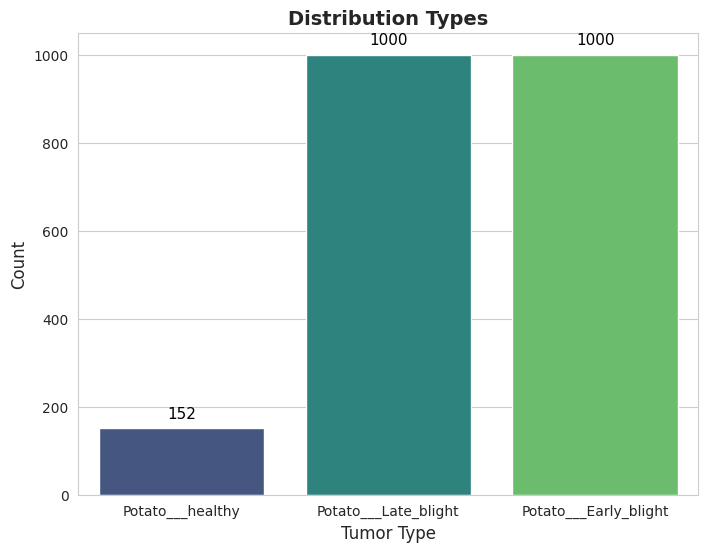

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax)

ax.set_title("Distribution Types", fontsize=14, fontweight="bold")
ax.set_xlabel("Tumor Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/ 2.,p.get_height()), ha='center', va='bottom', fontsize=11, color='black', xytext=(0,5), textcoords='offset points')
plt.show();

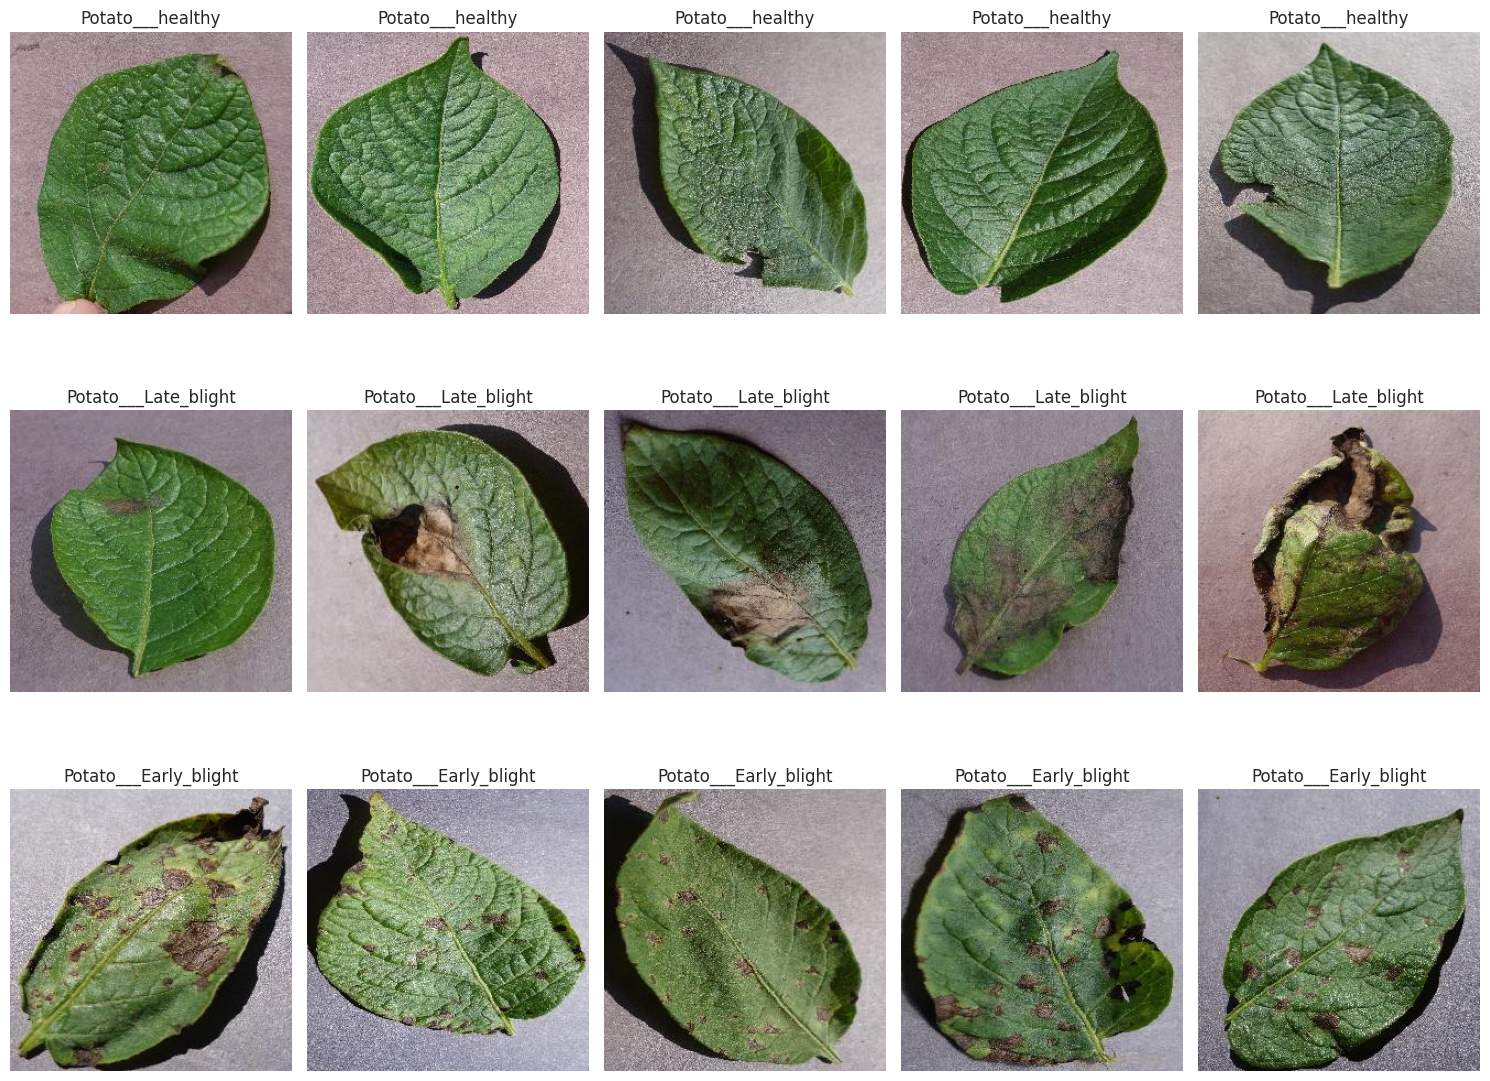

In [13]:
import cv2
import warnings
warnings.filterwarnings("ignore")

num_images = 5

plt.figure(figsize=(15,12))

for i, category in enumerate(categories):
    category_images = df[df['label'] == category]['image_path'].iloc[:num_images]

    for j, img_path in enumerate(category_images):

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(categories), num_images,  i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)

plt.tight_layout()
plt.show();

In [14]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df['category_encoded'] = label_encoder.fit_transform(df['label'])

label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_),label_encoder.classes_))
print("Label mapping:", label_mapping)

df = df[['image_path', 'category_encoded']]

from sklearn.utils import resample
max_count = df['category_encoded'].value_counts().max()

dfs = []
for category in df['category_encoded'].unique():
    class_subset = df[df['category_encoded'] == category]
    class_unsampled = resample(class_subset, replace=True, n_samples = max_count, random_state = 42)
    dfs.append(class_unsampled)

df_balanced = pd.concat(dfs).sample(frac = 1, random_state = 42).reset_index(drop = True)
df_balanced['category_encoded'].value_counts()

df_resampled = df_balanced
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

Label mapping: {np.int64(0): 'Potato___Early_blight', np.int64(1): 'Potato___Late_blight', np.int64(2): 'Potato___healthy'}


In [15]:
df_resampled["category_encoded"].value_counts()

,count
category_encoded,
1,1000
2,1000
0,1000


In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size = 0.8,
    shuffle = True,
    random_state = 42,
    stratify = df_resampled['category_encoded']
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size = 0.5,
    shuffle = True,
    random_state = 42,
    stratify = temp_df_new['category_encoded']
)

batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale = 1./255)

ts_gen = ImageDataGenerator(rescale = 1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col = 'image_path',
    y_col = 'category_encoded',
    target_size = img_size,
    class_mode = 'sparse',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col = 'image_path',
    y_col = 'category_encoded',
    target_size = img_size,
    class_mode = 'sparse',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col = 'image_path',
    y_col = 'category_encoded',
    target_size = img_size,
    class_mode = 'sparse',
    color_mode = 'rgb',
    shuffle = False,
    batch_size = batch_size
)


Found 2400 validated image filenames belonging to 3 classes.
Found 300 validated image filenames belonging to 3 classes.
Found 300 validated image filenames belonging to 3 classes.


In [17]:
import tensorflow as tf
print("Number of GPUs Available:", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU is set for TensorFlow")
  except RuntimeError as e:
        print(e)


Number of GPUs Available: 1
GPU is set for TensorFlow


In [18]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Lambda, Conv2D, MaxPooling2D,
                                     Flatten, Dense, Reshape, Concatenate,
                                     GlobalAveragePooling1D, Softmax, Multiply)
from tensorflow.keras.models import Model


num_classes = len(train_df_new['category_encoded'].unique())

In [19]:
def split_image(image):
    upper_half = image[:, :img_size[0]//2, :, :]
    lower_half = image[:, img_size[0]//2:, :, :]
    return upper_half, lower_half

def flip_lower_half(lower_half):
    return tf.image.flip_left_right(lower_half)

In [20]:
input_layer = Input(shape=img_shape)

upper_half, lower_half = Lambda(split_image)(input_layer)
lower_half_flipped = Lambda(flip_lower_half)(lower_half)

In [21]:
upper = Conv2D(32, (3, 3), activation='relu', padding='same')(upper_half)
upper = MaxPooling2D((2, 2))(upper)
upper = Conv2D(64, (3, 3), activation='relu', padding='same')(upper)
upper = MaxPooling2D((2, 2))(upper)
upper = Conv2D(128, (3, 3), activation='relu', padding='same')(upper)
upper = MaxPooling2D((2, 2))(upper)
upper = Flatten()(upper)
upper_dense = Dense(512, activation='relu')(upper)
upper_reshape = Reshape((1, 512))(upper_dense)

In [22]:
lower = Conv2D(32, (3, 3), activation='relu',
padding='same')(lower_half_flipped)
lower = MaxPooling2D((2, 2))(lower)
lower = Conv2D(64, (3, 3), activation='relu', padding='same')(lower)
lower = MaxPooling2D((2, 2))(lower)
lower = Conv2D(128, (3, 3), activation='relu', padding='same')(lower)
lower = MaxPooling2D((2, 2))(lower)
lower = Flatten()(lower)
lower_dense = Dense(512, activation='relu')(lower)
lower_reshape = Reshape((1, 512))(lower_dense)

In [23]:
concat_seq = Concatenate(axis=1)([upper_reshape, lower_reshape])

similarity_scores = tf.keras.layers.Dot(axes=-1,normalize=True)([upper_reshape, lower_reshape])

attention_weights = Softmax(axis=1)(similarity_scores)

attended = Multiply()([attention_weights, upper_reshape])

combined = Concatenate(axis=-1)([attended, lower_reshape])
combined = Reshape((1024,))(combined)

In [24]:
fc1 = Dense(256, activation='relu')(combined)
fc2 = Dense(128, activation='relu')(fc1)

output = Dense(num_classes, activation='softmax')(fc2)

In [25]:
model = Model(inputs=input_layer, outputs=output)
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ [(None, 112, 224, │          0 │ input_layer[0][0] │
│                     │ 3), (None, 112,   │            │                   │
│                     │ 224, 3)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 112, 224,  │          0 │ lambda[0][1]      │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 224,  │        896 │ lambda[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 224,  │        896 │ lambda_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 112,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 56, 112,   │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 112,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 112,   │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 56,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 28, 56,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 56,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 28,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 14, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50176)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50176)     │          0 │ max_pooling2d_5[

 Total params: 51,863,427 (197.84 MB)

 Trainable params: 51,863,427 (197.84 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=15,
    batch_size=batch_size
)

Epoch 1/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.5478 - loss: 0.9494 - val_accuracy: 0.7333 - val_loss: 0.5517
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8728 - loss: 0.3301 - val_accuracy: 0.9367 - val_loss: 0.1690
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9558 - loss: 0.1156 - val_accuracy: 0.9533 - val_loss: 0.1111
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.9741 - loss: 0.0654 - val_accuracy: 0.9633 - val_loss: 0.0989
Epoch 5/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9819 - loss: 0.0508 - val_accuracy: 0.9400 - val_loss: 0.1479
Epoch 6/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9689 - loss: 0.0958 - val_accuracy: 0.9700 - val_loss: 0.0856
Epoch 7/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9862 - loss: 0.0459 - val_accuracy: 0.9400 - val_loss: 0.1765
Epoch 8/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9922 - loss: 0.0289 - val_ac

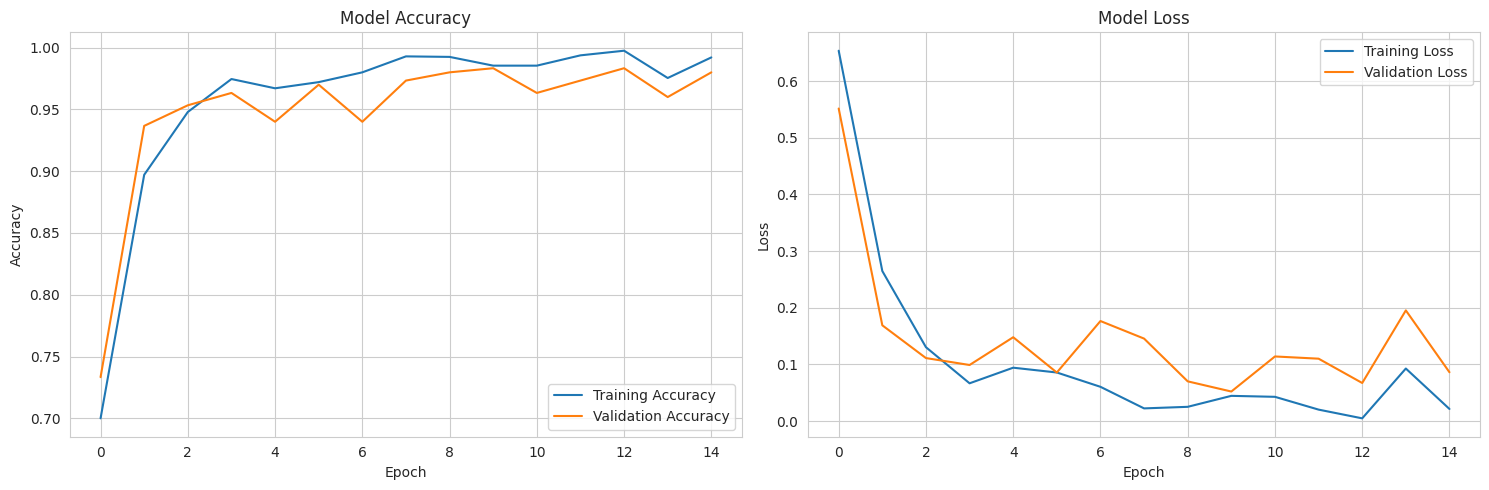

In [27]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  ax1.plot(history.history['accuracy'], label='Training Accuracy')
  ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
  ax1.set_title('Model Accuracy')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy')
  ax1.legend()
  ax1.grid(True)
  ax2.plot(history.history['loss'], label='Training Loss')
  ax2.plot(history.history['val_loss'], label='Validation Loss')
  ax2.set_title('Model Loss')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Loss')
  ax2.legend()
  ax2.grid(True)
  plt.tight_layout()
  plt.show()
plot_training_history(history)

In [28]:
print("Final Epoch Validation Accuracy: ", history.history['val_accuracy'][-1]*100)
print("Final Epoch Validation Loss: ", history.history['val_loss'][-1])

Final Epoch Validation Accuracy:  98.00000190734863
Final Epoch Validation Loss:  0.08609199523925781


In [29]:
test_loss, test_accuracy = model.evaluate(test_gen_new)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9826 - loss: 0.0989
Test Accuracy: 0.9767, Test Loss: 0.1435


In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
test_gen_new.reset()
y_pred = model.predict(test_gen_new)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen_new.classes

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


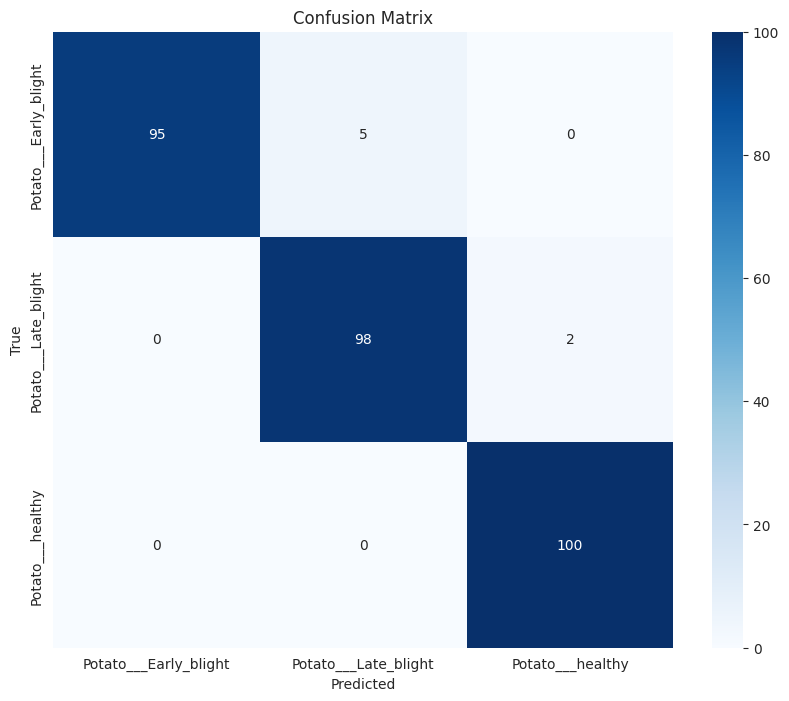

In [32]:
class_names = label_encoder.classes_

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [33]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes,
target_names=class_names))


Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       1.00      0.95      0.97       100
 Potato___Late_blight       0.95      0.98      0.97       100
     Potato___healthy       0.98      1.00      0.99       100

             accuracy                           0.98       300
            macro avg       0.98      0.98      0.98       300
         weighted avg       0.98      0.98      0.98       300

